In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import cv2
import re
import logging
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
import skimage
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import json
from datetime import datetime


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configure Neurite backend for VoxelMorph
os.environ['NEURITE_BACKEND'] = 'tensorflow'  # Must be set BEFORE importing neurite/voxelmorph
import neurite
from data.voxelmorph import voxelmorph as vxm



# Verify installed packages
print("\n--- Package Versions ---")
print(f"- Python: {sys.version.split()[0]}")
print(f"- TensorFlow: {tf.__version__}")
print(f"- VoxelMorph: {vxm.__version__ if hasattr(vxm, '__version__') else 'custom'}")
print(f"- Neurite: {neurite.__version__}")
print(f"- OpenCV: {cv2.__version__}")
print(f"- scikit-image: {skimage.__version__}")
print(f"- Matplotlib: {matplotlib.__version__}")
print(f"- tqdm: {tqdm.__version__}")
print(f"- SciPy: {scipy.__version__}")


# Set up environment paths
print("\n--- Environment Configuration ---")
print(f"Neurite backend: {neurite.backend}")
print(f"VoxelMorph path: {os.path.dirname(vxm.__file__)}")
print(f"Python path: {sys.path[:3]}...")



# Define data directories based on environment
LOCAL_DATA_DIR = './data'  # Default data directory for local execution
print(f"Using data directory: {LOCAL_DATA_DIR}")



--- Package Versions ---
- Python: 3.10.9
- TensorFlow: 2.19.0
- VoxelMorph: 0.2
- Neurite: 0.2
- OpenCV: 4.11.0
- scikit-image: 0.25.2
- Matplotlib: 3.10.1
- tqdm: 4.67.1
- SciPy: 1.15.2

--- Environment Configuration ---
Neurite backend: tensorflow
VoxelMorph path: d:\study\graduation_project\VXM\data\voxelmorph\voxelmorph
Python path: ['c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\lib']...
Using data directory: ./data


In [2]:
def create_path_structure(base_path):
    """Create and return a dictionary with all necessary data paths"""
    paths = {
        # Base paths
        'BASE_DATA_PATH': base_path,
        'MODELS_BASE_PATH': os.path.join(base_path, 'Models'),
        
        # ACDC and Sunnybrook paths
        'ACDC_BASE': '',
        'SUNNYBROOK_BASE': '',
        
        # Regular data paths
        'train_data': os.path.join(base_path, 'train'),
        'val_data': os.path.join(base_path, 'val'),
        'test_data': os.path.join(base_path, 'test'),
        'mask_data': os.path.join(base_path, 'ACDC-Masks-1'),
        'MODEL_TESTING_PATH': os.path.join(base_path, 'model_testing'),
        
        # Simulated data paths
        'train_simulated_data': os.path.join(base_path, 'Simulated_train'),
        'val_simulated_data': os.path.join(base_path, 'Simulated_val'),
        'test_simulated_data': os.path.join(base_path, 'Simulated_test'),
        'mask_simulated_data': os.path.join(base_path, 'Simulated_masks'),
        'displacement_simulated_data': os.path.join(base_path, 'Simulated_displacements'),
    }
    
    # Convenience aliases
    paths['SIMULATED_DATA_PATH'] = paths['test_simulated_data']
    paths['SIMULATED_MASK_PATH'] = paths['mask_simulated_data']
    paths['SIMULATED_DISP_PATH'] = paths['displacement_simulated_data']
    
    return paths

def check_paths(paths):
    """Verify existence of required paths with enhanced feedback"""
    missing_paths = []
    existing_paths = []

    print("\nChecking data paths:")
    for name, path in paths.items():
        if not isinstance(path, str) or not path:  # Skip empty paths or non-string values
            continue
        exists = os.path.exists(path)
        status = "✓" if exists else "✗"
        print(f"  {status} {name}: {path}")

        if exists:
            existing_paths.append(path)
        else:
            missing_paths.append(path)

    return existing_paths, missing_paths

def validate_environment(paths):
    """Validate paths and provide appropriate error messages"""
    paths_to_check = {
        'Simulated Training': paths['train_simulated_data'],
        'Simulated Validation': paths['val_simulated_data'],
        'Simulated Testing': paths['test_simulated_data'],
        'Simulated Masks': paths['mask_simulated_data'],
        'Simulated Displacements': paths['displacement_simulated_data'],
        'Train Data': paths['train_data'],
        'Validation Data': paths['val_data'],
        'Test Data': paths['test_data'],
        'Mask Data': paths['mask_data'],
    }

    existing, missing = check_paths(paths_to_check)

    if missing:
        print("\n⚠️ Missing paths detected!")
        base_dir = paths['BASE_DATA_PATH']
        print(f"Please ensure your local data directory ({base_dir}) contains:")
        print("- Simulated_train/Simulated_val/Simulated_test folders")
        print("- Simulated_masks folder")
        print("- Simulated_displacements folder")
        print("- ACDC-Masks-1 folder")
        print("- model_testing")
        print("- train/val/test folders")
        # Uncomment to enforce strict checking
            # raise FileNotFoundError("Missing required data paths")
    
    return len(missing) == 0

def create_model_config():
    """Create model configuration dictionary"""
    return {
        # 1. No Mask (Baseline)
        'no_mask': {
            'name': 'voxelmorph_no_mask',
            'use_mask': False,
            'use_mse_mask': False,
            'use_smoothness_mask': False
        },
        # # Commented configurations
        # 'mse_mask': {
        #     'name': 'voxelmorph_mse_mask',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': False
        # },
        # 'smoothness_mask': {
        #     'name': 'voxelmorph_smoothness_mask',
        #     'use_mask': True,
        #     'use_mse_mask': False,
        #     'use_smoothness_mask': True
        # },
        # 'both_masks': {
        #     'name': 'voxelmorph_both_masks',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': True
        # }
    }

def create_kernel_configs():
    """Create kernel configuration dictionary"""
    return {
        'default': {
            'encoder': [[3], [3], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first5': {
            'encoder': [[5], [3], [3], [3]], # first layer 5 rest is 3
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first7_second5': {
            'encoder': [[7], [5], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        }
    }

def setup_model_directories(model_config, kernel_configs, lambdas, models_base_path):
    """Generate model variable mappings and create necessary directories"""
    model_var_map = {}
    
    # Generate mappings
    for model_key in model_config:
        for kernel_key in kernel_configs:
            for lambda_val in lambdas:
                # Create a clean variable name
                var_name = f"vm_model_{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}".replace('.', '_')
                config_key = f"{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
                model_var_map[config_key] = var_name
                
                # Add path to model config
                folder_path = os.path.join(models_base_path, 
                                          f"{model_config[model_key]['name']}_kernel_{kernel_key}_lambda_{lambda_val:.3f}")
                model_config[model_key][f'kernel_{kernel_key}_lambda_{lambda_val:.3f}'] = {
                    'folder': folder_path
                }
                
                # Create directories
                os.makedirs(os.path.join(folder_path, 'weights'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'results'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'logs'), exist_ok=True)
    
    return model_var_map

# Initialize everything
# Define lambda values
# LAMBDAS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# LAMBDAS = [0.016, 0.033, 0.066, 0.1]
LAMBDAS = [0.1]
# Alternative lambdas: [0.016, 0.033, 0.066, 0.1, 0.3, 0.5]

# Setup paths
DATA_PATHS = create_path_structure(LOCAL_DATA_DIR)
# Expose all paths as individual variables for backward compatibility
for key, value in DATA_PATHS.items():
    globals()[key] = value

# Create and validate model configurations
MODEL_CONFIG = create_model_config()
KERNEL_CONFIGS = create_kernel_configs()
KERNEL_KEYS = list(KERNEL_CONFIGS.keys())

# Validate environment
is_valid = validate_environment(DATA_PATHS)

# Setup model directories and create variable mappings
MODEL_VAR_MAP = setup_model_directories(MODEL_CONFIG, KERNEL_KEYS, LAMBDAS, DATA_PATHS['MODELS_BASE_PATH'])

USE_CUSTOM_VXM = True  # Set to True if using custom VoxelMorph implementation


Checking data paths:
  ✓ Simulated Training: ./data\Simulated_train
  ✓ Simulated Validation: ./data\Simulated_val
  ✓ Simulated Testing: ./data\Simulated_test
  ✓ Simulated Masks: ./data\Simulated_masks
  ✓ Simulated Displacements: ./data\Simulated_displacements
  ✓ Train Data: ./data\train
  ✓ Validation Data: ./data\val
  ✓ Test Data: ./data\test
  ✓ Mask Data: ./data\ACDC-Masks-1


In [3]:
#### Model Creation
##### MSE Loss
class MSE:
    """
    Sigma-weighted mean squared error for image reconstruction.
    """

    def __init__(self, image_sigma=1.0):
        self.image_sigma = image_sigma

    def mse(self, y_true, y_pred):
        return K.square(y_true - y_pred)

    def loss(self, y_true, y_pred, reduce='mean'):
        # compute mse
        mse = self.mse(y_true, y_pred)

        mask = y_true[..., 1]  # Second channel for fixed mask
        # apply mask
        mse = mse * tf.expand_dims(mask, axis=-1)

        # reduce
        if reduce == 'mean':
            mse = K.mean(mse)
        elif reduce == 'max':
            mse = K.max(mse)
        elif reduce is not None:
            raise ValueError(f'Unknown MSE reduction type: {reduce}')
        # loss
        return 1.0 / (self.image_sigma ** 2) * mse

##### Smootheness Loss
class Grad:
    """
    N-D gradient loss.
    loss_mult can be used to scale the loss value - this is recommended if
    the gradient is computed on a downsampled vector field (where loss_mult
    is equal to the downsample factor).
    """

    def __init__(self, penalty='l1', loss_mult=None, vox_weight=None):
        self.penalty = penalty
        self.loss_mult = loss_mult
        self.vox_weight = vox_weight

    def _diffs(self, y):
        vol_shape = y.get_shape().as_list()[1:-1]
        ndims = len(vol_shape)

        df = [None] * ndims
        for i in range(ndims):
            d = i + 1
            # permute dimensions to put the ith dimension first
            r = [d, *range(d), *range(d + 1, ndims + 2)]
            yp = K.permute_dimensions(y, r)
            dfi = yp[1:, ...] - yp[:-1, ...]

            if self.vox_weight is not None:
                w = K.permute_dimensions(self.vox_weight, r)
                # TODO: Need to add square root, since for non-0/1 weights this is bad.
                dfi = w[1:, ...] * dfi

            # permute back
            # note: this might not be necessary for this loss specifically,
            # since the results are just summed over anyway.
            r = [*range(1, d + 1), 0, *range(d + 1, ndims + 2)]
            df[i] = K.permute_dimensions(dfi, r)

        return df

    def loss(self, y_true, y_pred):
        """
        returns Tensor of size [bs]
        """
        mask = y_true[..., 1]  # [batch, H, W]
        mask = tf.expand_dims(mask, -1)  # [batch, H, W, 1]

        # Resize the mask to match the spatial dimensions of y_pred
        target_size = tf.shape(y_pred)[1:3]  # assuming y_pred shape: [batch, new_H, new_W, channels]
        # Use bilinear interpolation for continuous values
        mask = tf.image.resize(mask, size=target_size, method="bilinear")

        self.vox_weight = mask

        # Reset y_true[..., 1] to zero to restore it as zero_phi
        x_channel = y_true[..., 0:1]  # [batch, H, W, 1]
        zero_channel = tf.zeros_like(x_channel)  # [batch, H, W, 1]
        y_true = tf.concat([x_channel, zero_channel], axis=-1)  # [batch, H, W, 2]

        if self.penalty == 'l1':
            dif = [tf.abs(f) for f in self._diffs(y_pred)]
        else:
            assert self.penalty == 'l2', 'penalty can only be l1 or l2. Got: %s' % self.penalty
            dif = [f * f for f in self._diffs(y_pred)]

        df = [tf.reduce_mean(K.batch_flatten(f), axis=-1) for f in dif]
        grad = tf.add_n(df) / len(df)

        if self.loss_mult is not None:
            grad *= self.loss_mult

        return grad

    def mean_loss(self, y_true, y_pred):
        """
        returns Tensor of size ()
        """

        return K.mean(self.loss(y_true, y_pred))
##### Model params
def create_voxelmorph_model(use_mse_mask=False, use_smoothness_mask=False, kernel_config='default', lambda_val=0.1):
    input_shape = (128, 128)
    src_feats = 1  # Moving image has 1 channel
    trg_feats = 3 if (use_mse_mask or use_smoothness_mask) else 1  # Fixed image + mask channels

    # Input layers
    source_input = tf.keras.Input(shape=(*input_shape, src_feats), name='source_input')
    target_input = tf.keras.Input(shape=(*input_shape, trg_feats), name='target_input')

    # Build VxmDense model
    nb_features = [
        [16, 32, 32, 32],  # encoder
        [32, 32, 32, 32, 32, 16, 16]  # decoder
    ]

    # Get kernel configuration
    kernels = KERNEL_CONFIGS[kernel_config] if USE_CUSTOM_VXM else None

    # Create base VxmDense model
    vm_model = vxm.networks.VxmDense(
        inshape=input_shape,
        nb_unet_features=nb_features,
        unet_kernel_sizes=kernels,
        src_feats=src_feats,
        trg_feats=trg_feats,
        input_model=tf.keras.Model(inputs=[source_input, target_input], outputs=[source_input, target_input]),
        int_steps=5,
        reg_field = 'warp'
    )

    # Configure losses
    losses = []
    loss_weights = []

    # Loss functions
    losses = []
    loss_weights = []

    # 1. MSE Loss (with optional mask)
    if use_mse_mask:
        # Custom MSE loss with BG-to-myocardium ratio mask
        losses.append(MSE().loss)
    else:
        losses.append(vxm.losses.MSE().loss)

    loss_weights.append(1)  # Weight for similarity loss

    # 2. Smoothness Loss (with optional mask)
    if use_smoothness_mask:
        # Custom smoothness loss
        losses.append(Grad('l2').loss)
    else:
        losses.append(vxm.losses.Grad('l2').loss)

    loss_weights.append(lambda_val)  # Weight for smoothness loss

    # Compile model
    vm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=losses,
        loss_weights=loss_weights
    )
    return vm_model



##### Strain calculation

In [4]:
def compute_strains(FrameDisplX, FrameDisplY, deltaX, deltaY):
    """
    Compute principal strains (Ep1, Ep2) and incompressibility strain (Ep3)
    from displacement fields.

    Args:
        FrameDisplX (np.ndarray): X displacement field (shape: H, W, T).
        FrameDisplY (np.ndarray): Y displacement field (shape: H, W, T).
        deltaX (float): Pixel spacing in the X direction (mm).
        deltaY (float): Pixel spacing in the Y direction (mm).

    Returns:
        Ep1All (np.ndarray): Principal strain 1 (shape: H, W, T).
        Ep2All (np.ndarray): Principal strain 2 (shape: H, W, T).
        Ep3All (np.ndarray): Incompressibility strain (shape: H, W, T).
    """
    # Compute spatial gradients
    UXx, UXy = np.gradient(FrameDisplX, deltaX, deltaY, axis=(0, 1))
    UYx, UYy = np.gradient(FrameDisplY, deltaX, deltaY, axis=(0, 1))

    # Compute Eulerian strain tensor components
    ExxAll = (2 * UXx - (UXx**2 + UYx**2)) / 2
    ExyAll = (UXy + UYx - (UXx * UXy + UYx * UYy)) / 2
    EyyAll = (2 * UYy - (UXy**2 + UYy**2)) / 2

    # Compute principal strains
    Ep1All = (ExxAll + EyyAll) / 2 + np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)
    Ep2All = (ExxAll + EyyAll) / 2 - np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)

    Ep1All, Ep2All, _ = enforce_full_principal_strain_order(Ep1All, Ep2All)

    # Compute incompressibility strain using the determinant rule
    Ep3All = 1 / ((1 + np.maximum(Ep1All, Ep2All)) * (1 + np.minimum(Ep1All, Ep2All))) - 1

    return Ep1All, Ep2All, Ep3All


def enforce_full_principal_strain_order(Ep1All, Ep2All, Ep3All=None):
    """
    Ensure Ep1All >= Ep2All >= Ep3All at every voxel (pixel) location.
    Sorts the three principal strains per point.

    Args:
        Ep1All (np.ndarray): First principal strain field.
        Ep2All (np.ndarray): Second principal strain field.
        Ep3All (np.ndarray): Third principal strain field (incompressibility strain).

    Returns:
        Ep1_sorted (np.ndarray): Largest principal strain.
        Ep2_sorted (np.ndarray): Middle principal strain.
        Ep3_sorted (np.ndarray): Smallest principal strain.
    """

    if Ep3All is not None:
        # Stack all principal strains along a new axis
        strain_stack = np.stack([Ep1All, Ep2All, Ep3All], axis=0)  # Shape (3, H, W, T)
    else:
        # Stack only the first two principal strains
        strain_stack = np.stack([Ep1All, Ep2All, Ep2All], axis=0) # Shape (2, H, W, T)
    # Sort along the new axis (axis=0) descending
    strain_sorted = np.sort(strain_stack, axis=0)[::-1, ...]  # Reverse to get descending

    Ep1_sorted = strain_sorted[0]
    Ep2_sorted = strain_sorted[1]
    Ep3_sorted = strain_sorted[2]

    return Ep1_sorted, Ep2_sorted, Ep3_sorted


##### visualize

In [24]:
import numpy as np
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

def enforce_full_principal_strain_order(Ep1All, Ep2All, Ep3All=None):
  """
  Ensure Ep1All >= Ep2All >= Ep3All at every voxel (pixel) location.
  Sorts the three principal strains per point.
  """
  if Ep3All is not None:
    strain_stack = np.stack([Ep1All, Ep2All, Ep3All], axis=0)
  else:
    strain_stack = np.stack([Ep1All, Ep2All, Ep2All], axis=0)
  strain_sorted = np.sort(strain_stack, axis=0)[::-1, ...]
  Ep1_sorted = strain_sorted[0]
  Ep2_sorted = strain_sorted[1]
  Ep3_sorted = strain_sorted[2]
  return Ep1_sorted, Ep2_sorted, Ep3_sorted

def limit_strain_range(FrameDisplX, FrameDisplY, deltaX=1, deltaY=1):
  """
  Compute principal strains (Ep1, Ep2) and incompressibility strain (Ep3) 
  from displacement fields.
  """
  # Compute spatial gradients
  UXx, UXy = np.gradient(FrameDisplX, deltaX, deltaY, axis=(0, 1))
  UYx, UYy = np.gradient(FrameDisplY, deltaX, deltaY, axis=(0, 1))

  # Compute Eulerian strain tensor components
  ExxAll = (2 * UXx - (UXx**2 + UYx**2)) / 2
  ExyAll = (UXy + UYx - (UXx * UXy + UYx * UYy)) / 2
  EyyAll = (2 * UYy - (UXy**2 + UYy**2)) / 2

  # Compute principal strains
  Ep1All = (ExxAll + EyyAll) / 2 + np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)
  Ep2All = (ExxAll + EyyAll) / 2 - np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)

  Ep1All, Ep2All, _ = enforce_full_principal_strain_order(Ep1All, Ep2All)

  # Compute incompressibility strain using the determinant rule
  Ep3All = 1 / ((1 + np.maximum(Ep1All, Ep2All)) * (1 + np.minimum(Ep1All, Ep2All))) - 1

  final_tensor = {}
  final_tensor['E1'] = Ep1All
  final_tensor['E2'] = Ep2All
  final_tensor['E3'] = Ep3All

  return None, None, final_tensor, final_tensor, np.max(Ep1All), np.max(Ep2All), np.min(Ep1All), np.min(Ep2All)

def apply_displacement(image, x_displacement, y_displacement):
  height, width = image.shape[:2]
  x, y = np.meshgrid(np.arange(width), np.arange(height))
  x_new = (x + x_displacement).astype(np.float32)
  y_new = (y + y_displacement).astype(np.float32)
  if hasattr(image, "numpy"):
    image = image.numpy()
  displaced_image = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_REFLECT)
  return displaced_image

def add_colorbar(fig, ax, im, label=""):
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = fig.colorbar(im, cax=cax)
  cbar.ax.set_ylabel(label, fontsize=12)
  cbar.ax.tick_params(labelsize=10)

def create_interactive_plots(data, sample_idx, MODEL_TESTING_PATH, model_name="model"):
  """
  Create interactive plots with core images, strain analysis, and strain overlays.
  """
  moving = data['moving']
  fixed = data['fixed']
  warped = data['warped']
  disp = data['displacements']
  mask = data['mask']

  result = limit_strain_range(disp[..., 0], disp[..., 1])
  dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = result

  fig, axes = plt.subplots(3, 5, figsize=(40, 21), constrained_layout=True)
  fig.suptitle(f"Sample {sample_idx} Analysis", fontsize=20, y=1.02)

  # --- First Row: Core Images ---
  images = [moving, fixed, warped]
  titles = ["Moving Image", "Fixed Image", "Warped Image"]
  Current_Row = 0
  for i, (img, title) in enumerate(zip(images, titles)):
    axes[Current_Row, i].imshow(img, cmap='gray')
    axes[Current_Row, i].set_title(title, fontsize=16)
    axes[Current_Row, i].axis('off')

  warped_norm = (warped - warped.min()) / (np.ptp(warped))
  fixed_norm = (fixed - fixed.min()) / (np.ptp(fixed))
  moving_norm = (moving - moving.min()) / (np.ptp(moving))

  rgb_wrpd_fxd = np.stack([warped_norm, fixed_norm, fixed_norm], axis=-1)
  axes[Current_Row, 3].imshow(rgb_wrpd_fxd)
  axes[Current_Row, 3].set_title("Warped (Red) over Fixed (RGB)", fontsize=20)
  axes[Current_Row, 3].axis('off')

  rgb_mvg_fxd = np.stack([moving_norm, fixed_norm, fixed_norm], axis=-1)
  axes[Current_Row, 4].imshow(rgb_mvg_fxd)
  axes[Current_Row, 4].set_title("Moving (Red) over Fixed (RGB)", fontsize=20)
  axes[Current_Row, 4].axis('off')

  # --- Second Row: Strain Analysis (Heatmaps) ---
  Current_Row = 2
  strain_min = min(np.min(final_strain_tensor['E1']), np.min(final_strain_tensor['E2']))
  strain_max = max(np.max(final_strain_tensor['E1']), np.max(final_strain_tensor['E2']))
  abs_max = max(abs(strain_min), abs(strain_max))
  vmin, vmax = -0.5, 0.5

  strain_images = [final_strain_tensor['E1'] * mask, final_strain_tensor['E2'] * mask]
  strain_titles = ["Final E1 Strain", "Final E2 Strain"]

  for i, (strain_img, title) in enumerate(zip(strain_images, strain_titles)):
    im = axes[Current_Row, i].imshow(strain_img, cmap='jet', vmin=vmin, vmax=vmax)
    axes[Current_Row, i].set_title(title, fontsize=16)
    axes[Current_Row, i].axis('off')
    add_colorbar(fig, axes[Current_Row, i], im, label="Strain (unitless)")

  diff = fixed - warped
  im6 = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
  axes[Current_Row, 2].set_title("Warped Difference", fontsize=16)
  axes[Current_Row, 2].axis('off')
  add_colorbar(fig, axes[Current_Row, 2], im6, label="Intensity Difference")

  axes[Current_Row, 3].axis('off')
  axes[Current_Row, 4].axis('off')

  # --- Third Row: Strain Overlays on Fixed Image ---
  Current_Row = 1
  overlay_titles = ["E1 Strain Overlay", "E2 Strain Overlay"]
  for i, (strain_img, title) in enumerate(zip(strain_images, overlay_titles)):
    axes[Current_Row, i].imshow(fixed, cmap='gray', alpha=0.95)
    im_overlay = axes[Current_Row, i].imshow(strain_img, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
    axes[Current_Row, i].set_title(title, fontsize=16)
    axes[Current_Row, i].axis('off')
    add_colorbar(fig, axes[Current_Row, i], im_overlay, label="Strain (unitless)")

  error_map = np.abs(fixed_norm - warped_norm)
  im = axes[Current_Row, 3].imshow(error_map, cmap='hot')
  axes[Current_Row, 3].set_title("F-W Local Registration Error Heatmap", fontsize=16)
  axes[Current_Row, 3].axis('off')
  add_colorbar(fig, axes[Current_Row, 3], im, label="Absolute Intensity Difference")

  error_map = np.abs(fixed_norm - moving_norm)
  im = axes[Current_Row, 4].imshow(error_map, cmap='hot')
  axes[Current_Row, 4].set_title("F-M Local Registration Error Heatmap", fontsize=16)
  axes[Current_Row, 4].axis('off')
  add_colorbar(fig, axes[Current_Row, 4], im, label="Absolute Intensity Difference")

  axes[Current_Row, 2].axis('off')

  save_path = f"sample_{model_name}_analysis.png"
  plt.savefig(save_path, bbox_inches='tight', dpi=300)
  plt.show()


##### Save Visualization

In [68]:
def save_images(moving, fixed, warped, disp, save_dir, batch_idx, fixed_mask= None):
    """Save enhanced visualizations with strain analysis and consistent difference maps."""
    os.makedirs(save_dir, exist_ok=True)
    batch_size = moving.shape[0]

    # Ensure fixed has shape (batch, H, W, 1)
    if fixed.shape[-1] != 1:
        fixed = fixed[..., :1]  # Take the image channel only
    # print(f"Fixed for save_images - Shape: {fixed.shape}, Min: {fixed.min():.4f}, Max: {fixed.max():.4f}")

    for i in range(batch_size):
        # Extract images with proper dimension handling
        moving_img = moving[i, ..., 0].squeeze()
        warped_img = warped[i, ..., 0].squeeze()
        fixed_img = fixed[i, ..., 0].squeeze()

        # Extract displacement fields
        frame_displ_y = disp[i, ..., 0]
        frame_displ_x = disp[i, ..., 1]
        # print(f"Sample {i} Displacement Stats: X min={frame_displ_x.min():.4f}, max={frame_displ_x.max():.4f}, mean={frame_displ_x.mean():.4f}")
        # print(f"Sample {i} Displacement Stats: Y min={frame_displ_y.min():.4f}, max={frame_displ_y.max():.4f}, mean={frame_displ_y.mean():.4f}")

        # Calculate strain
        result = compute_strains(frame_displ_x, frame_displ_y, 1.0, 1.0)
        Ep1All, Ep2All, Ep3All = result
        final_strain = {'E1': Ep1All, 'E2': Ep2All, 'E3': Ep3All}
        
        # Apply mask to strain if fixed_mask is provided
        if fixed_mask is not None:
            # Ensure mask is properly dimensioned
            mask = fixed_mask[i] if fixed_mask.ndim > 2 else fixed_mask
            # Apply mask to each strain component
            for key in final_strain:
                final_strain[key] = final_strain[key] * mask

        # Create a figure with 3 rows and 5 columns
        fig, axes = plt.subplots(3, 3, figsize=(40, 21), constrained_layout=True)
        fig.suptitle(f"Unsupervised No mask Default kernel Lambda = 0.1 Model", fontsize=34, y=1.02)
        # --- First Row: Core Images ---
        images = [moving_img, fixed_img, warped_img]
        titles = ["Moving Image", "Fixed Image", "Warped Image"]

        Current_Row = 0

        for j, (img, title) in enumerate(zip(images, titles)):
            axes[Current_Row, j].imshow(img, cmap='gray')
            axes[Current_Row, j].set_title(title, fontsize=28)
            axes[Current_Row, j].axis('off')

        # Create RGB image: R and G from warped, B from fixed
        warped_norm = (warped_img - warped_img.min()) / (np.ptp(warped_img))
        fixed_norm = (fixed_img - fixed_img.min()) / (np.ptp(fixed_img))
        moving_norm = (moving_img - moving_img.min()) / (np.ptp(moving_img))

        rgb_wrpd_fxd = np.stack([
            warped_norm,      # Red channel
            fixed_norm,      # Green channel
            fixed_norm        # Blue channel
        ], axis=-1)

        axes[1, 2].imshow(rgb_wrpd_fxd)
        axes[1, 2].set_title("Warped (Red) over Fixed (RGB)", fontsize=28)
        axes[1, 2].axis('off')

        rgb_mvg_fxd = np.stack([
            moving_norm,      # Red channel
            fixed_norm,      # Green channel
            fixed_norm        # Blue channel
        ], axis=-1)

        axes[2, 2].imshow(rgb_mvg_fxd)
        axes[2, 2].set_title("Moving (Red) over Fixed (RGB)", fontsize=28)
        axes[2, 2].axis('off')

        # --- Second Row: Strain Analysis (Heatmaps) ---
        Current_Row = 2
        strain_min = min(np.min(final_strain['E1']), np.min(final_strain['E2']))
        strain_max = max(np.max(final_strain['E1']), np.max(final_strain['E2']))
        abs_max = max(abs(strain_min), abs(strain_max))
        vmin, vmax = -abs_max, abs_max  # Symmetric colormap
        vmin, vmax = -0.5, 0.5  # Symmetric colormap

        strain_images = [final_strain['E1'], final_strain['E2']]
        strain_titles = ["Final E1 Strain", "Final E2 Strain"]

        for j, (strain_img, title) in enumerate(zip(strain_images, strain_titles)):
            im = axes[Current_Row, j].imshow(strain_img, cmap='jet', vmin=vmin, vmax=vmax)
            axes[Current_Row, j].set_title(title, fontsize=28)
            axes[Current_Row, j].axis('off')
            if j == 0:
                add_colorbar(fig, axes[Current_Row, j], im, label='')
            else:
                add_colorbar(fig, axes[Current_Row, j], im, label="Strain (unitless)")

        # diff = fixed_img - warped_img
        # im6 = axes[Current_Row, 2].imshow(diff, cmap='bwr', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
        # axes[Current_Row, 2].set_title("Warped Difference", fontsize=28)
        # axes[Current_Row, 2].axis('off')
        # add_colorbar(fig, axes[Current_Row, 2], im6, label="Intensity Difference")

        # axes[Current_Row, 3].axis('off')
        # axes[Current_Row, 4].axis('off')

        # --- Third Row: Strain Overlays on Fixed Image ---
        Current_Row = 1
        overlay_titles = ["E1 Strain Overlay", "E2 Strain Overlay"]

        for j, (strain_img, title) in enumerate(zip(strain_images, overlay_titles)):
            axes[Current_Row, j].imshow(fixed_img, cmap='gray', alpha=0.95)
            im_overlay = axes[Current_Row, j].imshow(strain_img, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)
            axes[Current_Row, j].set_title(title, fontsize=28)
            axes[Current_Row, j].axis('off')
            if j == 0:
                add_colorbar(fig, axes[Current_Row, j], im_overlay, label='')
            else:
                add_colorbar(fig, axes[Current_Row, j], im_overlay, label="Strain (unitless)")

        # error_map = np.abs(fixed_norm - warped_norm)
        # vmin_error = min(np.min(np.abs(fixed_norm - warped_norm)), np.min(np.abs(fixed_norm - moving_norm)))
        # vmax_error = max(np.max(np.abs(fixed_norm - warped_norm)), np.max(np.abs(fixed_norm - moving_norm)))

        # im = axes[Current_Row, 3].imshow(error_map, cmap='hot', vmin=vmin_error, vmax=vmax_error)
        # axes[Current_Row, 3].set_title("F-W Local Registration Error Heatmap", fontsize=28)
        # axes[Current_Row, 3].axis('off')
        # add_colorbar(fig, axes[Current_Row, 3], im, label="")

        # error_map = np.abs(fixed_norm - moving_norm)
        # im = axes[Current_Row, 4].imshow(error_map, cmap='hot', vmin=vmin_error, vmax=vmax_error)
        # axes[Current_Row, 4].set_title("F-M Local Registration Error Heatmap", fontsize=28)
        # axes[Current_Row, 4].axis('off')
        # add_colorbar(fig, axes[Current_Row, 4], im, label="Absolute Intensity Difference")

        # axes[Current_Row, 2].axis('off')

        # Save figure
        # plt.show()
        save_path = os.path.join(save_dir, f"sample_{i}_batch_{batch_idx}.png")
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.close(fig)

def add_colorbar(fig, ax, im, label):
    """Adds a colorbar to the given axes."""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)


In [58]:
# Load 2 frames od data 
moving_image_path = 'Best_model/patient5/patient_4d_frame_1.npy'
fixed_image_path = 'Best_model/patient5/patient_4d_frame_13.npy'
# moving_image_path = 'data/train/patient005/patient005_t01_z03.npy'
# fixed_image_path = 'data/train/patient005/patient005_t13_z03.npy'
# Load the images
moving_image = np.load(moving_image_path)
fixed_image = np.load(fixed_image_path)
# print the shapes of the images
print(f"Moving image shape: {moving_image.shape}")
print(f"Fixed image shape: {fixed_image.shape}")

Moving image shape: (128, 128)
Fixed image shape: (128, 128)


In [59]:
# Print min and max values of the images
print(f"Moving image min: {moving_image.min():.4f}, max: {moving_image.max():.4f}")
print(f"Fixed image min: {fixed_image.min():.4f}, max: {fixed_image.max():.4f}")
# make sure images are percentil normalized
moving_image = (moving_image - np.percentile(moving_image, 1)) / (np.percentile(moving_image, 99) - np.percentile(moving_image, 1))
fixed_image = (fixed_image - np.percentile(fixed_image, 1)) / (np.percentile(fixed_image, 99) - np.percentile(fixed_image, 1))
# print min and max values of the images after normalization
print(f"Normalized Moving image min: {moving_image.min():.4f}, max: {moving_image.max():.4f}")
print(f"Normalized Fixed image min: {fixed_image.min():.4f}, max: {fixed_image.max():.4f}")

Moving image min: 6.2353, max: 156.7248
Fixed image min: 7.1983, max: 192.0082
Normalized Moving image min: -0.0283, max: 1.0702
Normalized Fixed image min: -0.0170, max: 1.5804


In [60]:
# Load fixed image mask
fixed_mask_path = 'Best_model/patient5/patient_4d_frame_13_mask.npy'
fixed_mask = np.load(fixed_mask_path)
# keep only the left ventricle mask (value 1)
fixed_mask = (fixed_mask == 1).astype(np.float32)  # Convert to float32 for consistency

Text(0.5, 1.0, 'Fixed Image')

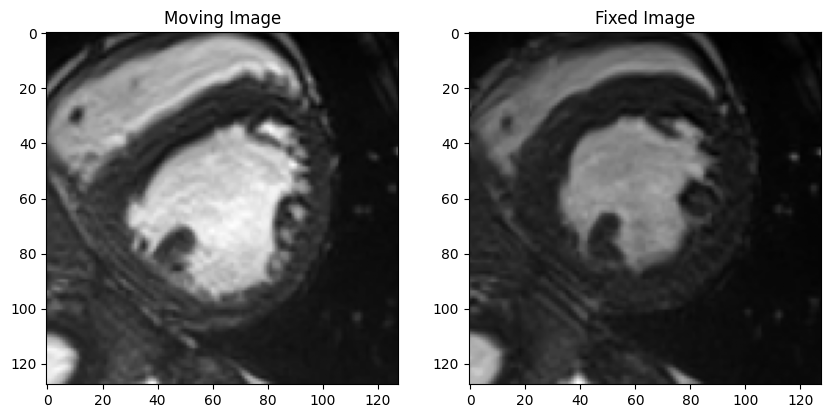

In [61]:
# Plot the images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(moving_image.squeeze(), cmap='gray')
plt.title('Moving Image')
plt.subplot(1, 2, 2)
plt.imshow(fixed_image.squeeze(), cmap='gray')
plt.title('Fixed Image')
# # plot mask over fixed image
# plt.imshow(fixed_mask.squeeze(), cmap='jet', alpha=0.5)
# plt.show()

In [62]:
# prepare images for prediction
moving_image = np.expand_dims(moving_image, axis=0)  # Add batch dimension
fixed_image = np.expand_dims(fixed_image, axis=0)  # Add batch dimension
# Ensure images have the correct shape
moving_image = np.expand_dims(moving_image, axis=-1)  # Add channel dimension
fixed_image = np.expand_dims(fixed_image, axis=-1)  # Add channel dimension

# Print new shapes
print(f"Moving image shape after expansion: {moving_image.shape}")
print(f"Fixed image shape after expansion: {fixed_image.shape}")

Moving image shape after expansion: (1, 128, 128, 1)
Fixed image shape after expansion: (1, 128, 128, 1)


In [63]:
# load model
# model_base_path = 'Models/VXM_kernel_changes_no_mask_both_data_evaluated/voxelmorph_no_mask_kernel_default_lambda_0.100/weights/best_model_val_loss_0.00320.weights.h5'
model_base_path = 'Models/VXM_kernel_changes_no_mask_both_data_evaluated/voxelmorph_no_mask_kernel_default_lambda_0.100/weights/epoch93_loss0.00373.weights.h5'
# model_base_path = 'Models/VXM_kernel_changes_no_mask_both_data_evaluated/voxelmorph_no_mask_kernel_first7_second5_lambda_1.000/weights/epoch58_loss0.00749.weights.h5'
# model_base_path = 'Models/VXM_kernel_changes_no_mask_both_data_evaluated/voxelmorph_no_mask_kernel_first7_second5_lambda_1.000/weights/epoch58_loss0.00749.weights.h5'
# model_base_path = 'Models/VXM_kernel_changes_no_mask_both_data_evaluated/voxelmorph_no_mask_kernel_default_lambda_0.100/final_model.keras'


# Define custom objects
custom_objects = {
    'Grad': Grad,
    'MSE': MSE,
    'Adam': tf.keras.optimizers.Adam,
    'vxm': vxm.losses  # If using original voxelmorph losses
}

# Recreate model architecture first
model = create_voxelmorph_model(
    use_mse_mask=False,
    use_smoothness_mask=False,
    kernel_config= 'default',
    lambda_val=1
)

# Load weights into architecture
model.load_weights(model_base_path)

c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [64]:
# check model summary
model.summary()

Model: "vxm_dense"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ source_input        │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_input        │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_inp… │ (None, 128, 128,  │          0 │ source_input[0][… │
│ (Concatenate)       │ 2)                │            │ target_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 128, 128,  │        304 │ vxm_dense_unet_i… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 128, 128,  │          0 │ vxm_dense_unet_e… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 64, 64,    │          0 │ vxm_dense_unet_e… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 64, 64,    │      4,640 │ vxm_dense_unet_e… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 64, 64,    │          0 │ vxm_dense_unet_e… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 32, 32,    │          0 │ vxm_dense_unet_e… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 32, 32,    │      9,248 │ vxm_dense_unet_e… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 32, 32,    │          0 │ vxm_dense_unet_e… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 16, 16,    │          0 │ vxm_dense_unet_e… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 16, 16,    │      9,248 │ vxm_dense_unet_e… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 16, 16,    │          0 │ vxm_dense_unet_e… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_enc… │ (None, 8, 8, 32)  │          0 │ vxm_dense_unet_e… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_dec… │ (None, 8, 8, 32)  │      9,248 │ vxm_dense_unet_e… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vxm_dense_unet_dec… │ (None, 8, 8, 32)  │          0 │ vxm_dense_unet_d

 Total params: 109,170 (426.45 KB)

 Trainable params: 109,170 (426.45 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Predict the deformation field
predictions = model.predict([moving_image, fixed_image])
# Extract the deformation field
warped, pred_disp = predictions
# Print the shapes of the predictions
print(f"Warped image shape: {warped.shape}")
print(f"Predicted displacement field shape: {pred_disp.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Warped image shape: (1, 128, 128, 1)
Predicted displacement field shape: (1, 128, 128, 2)


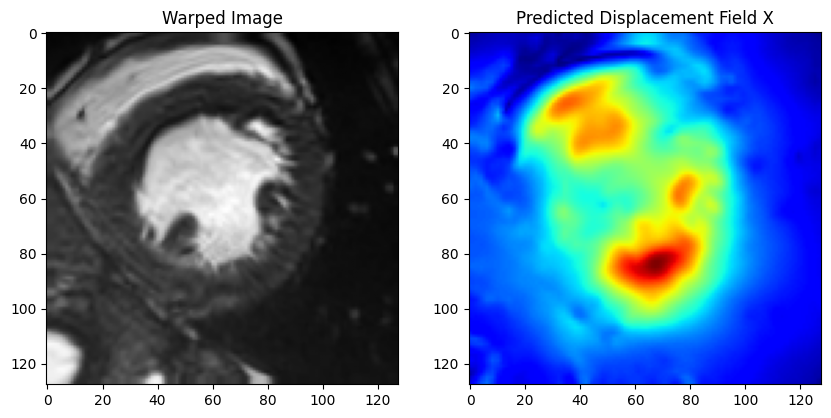

In [66]:
# plot warped image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(warped.squeeze(), cmap='gray')
plt.title('Warped Image')
magnitude = np.sqrt(np.sum(pred_disp**2, axis=-1))
plt.subplot(1, 2, 2)
plt.imshow(magnitude.squeeze(), cmap='jet')
plt.title('Predicted Displacement Field X')


plt.show()

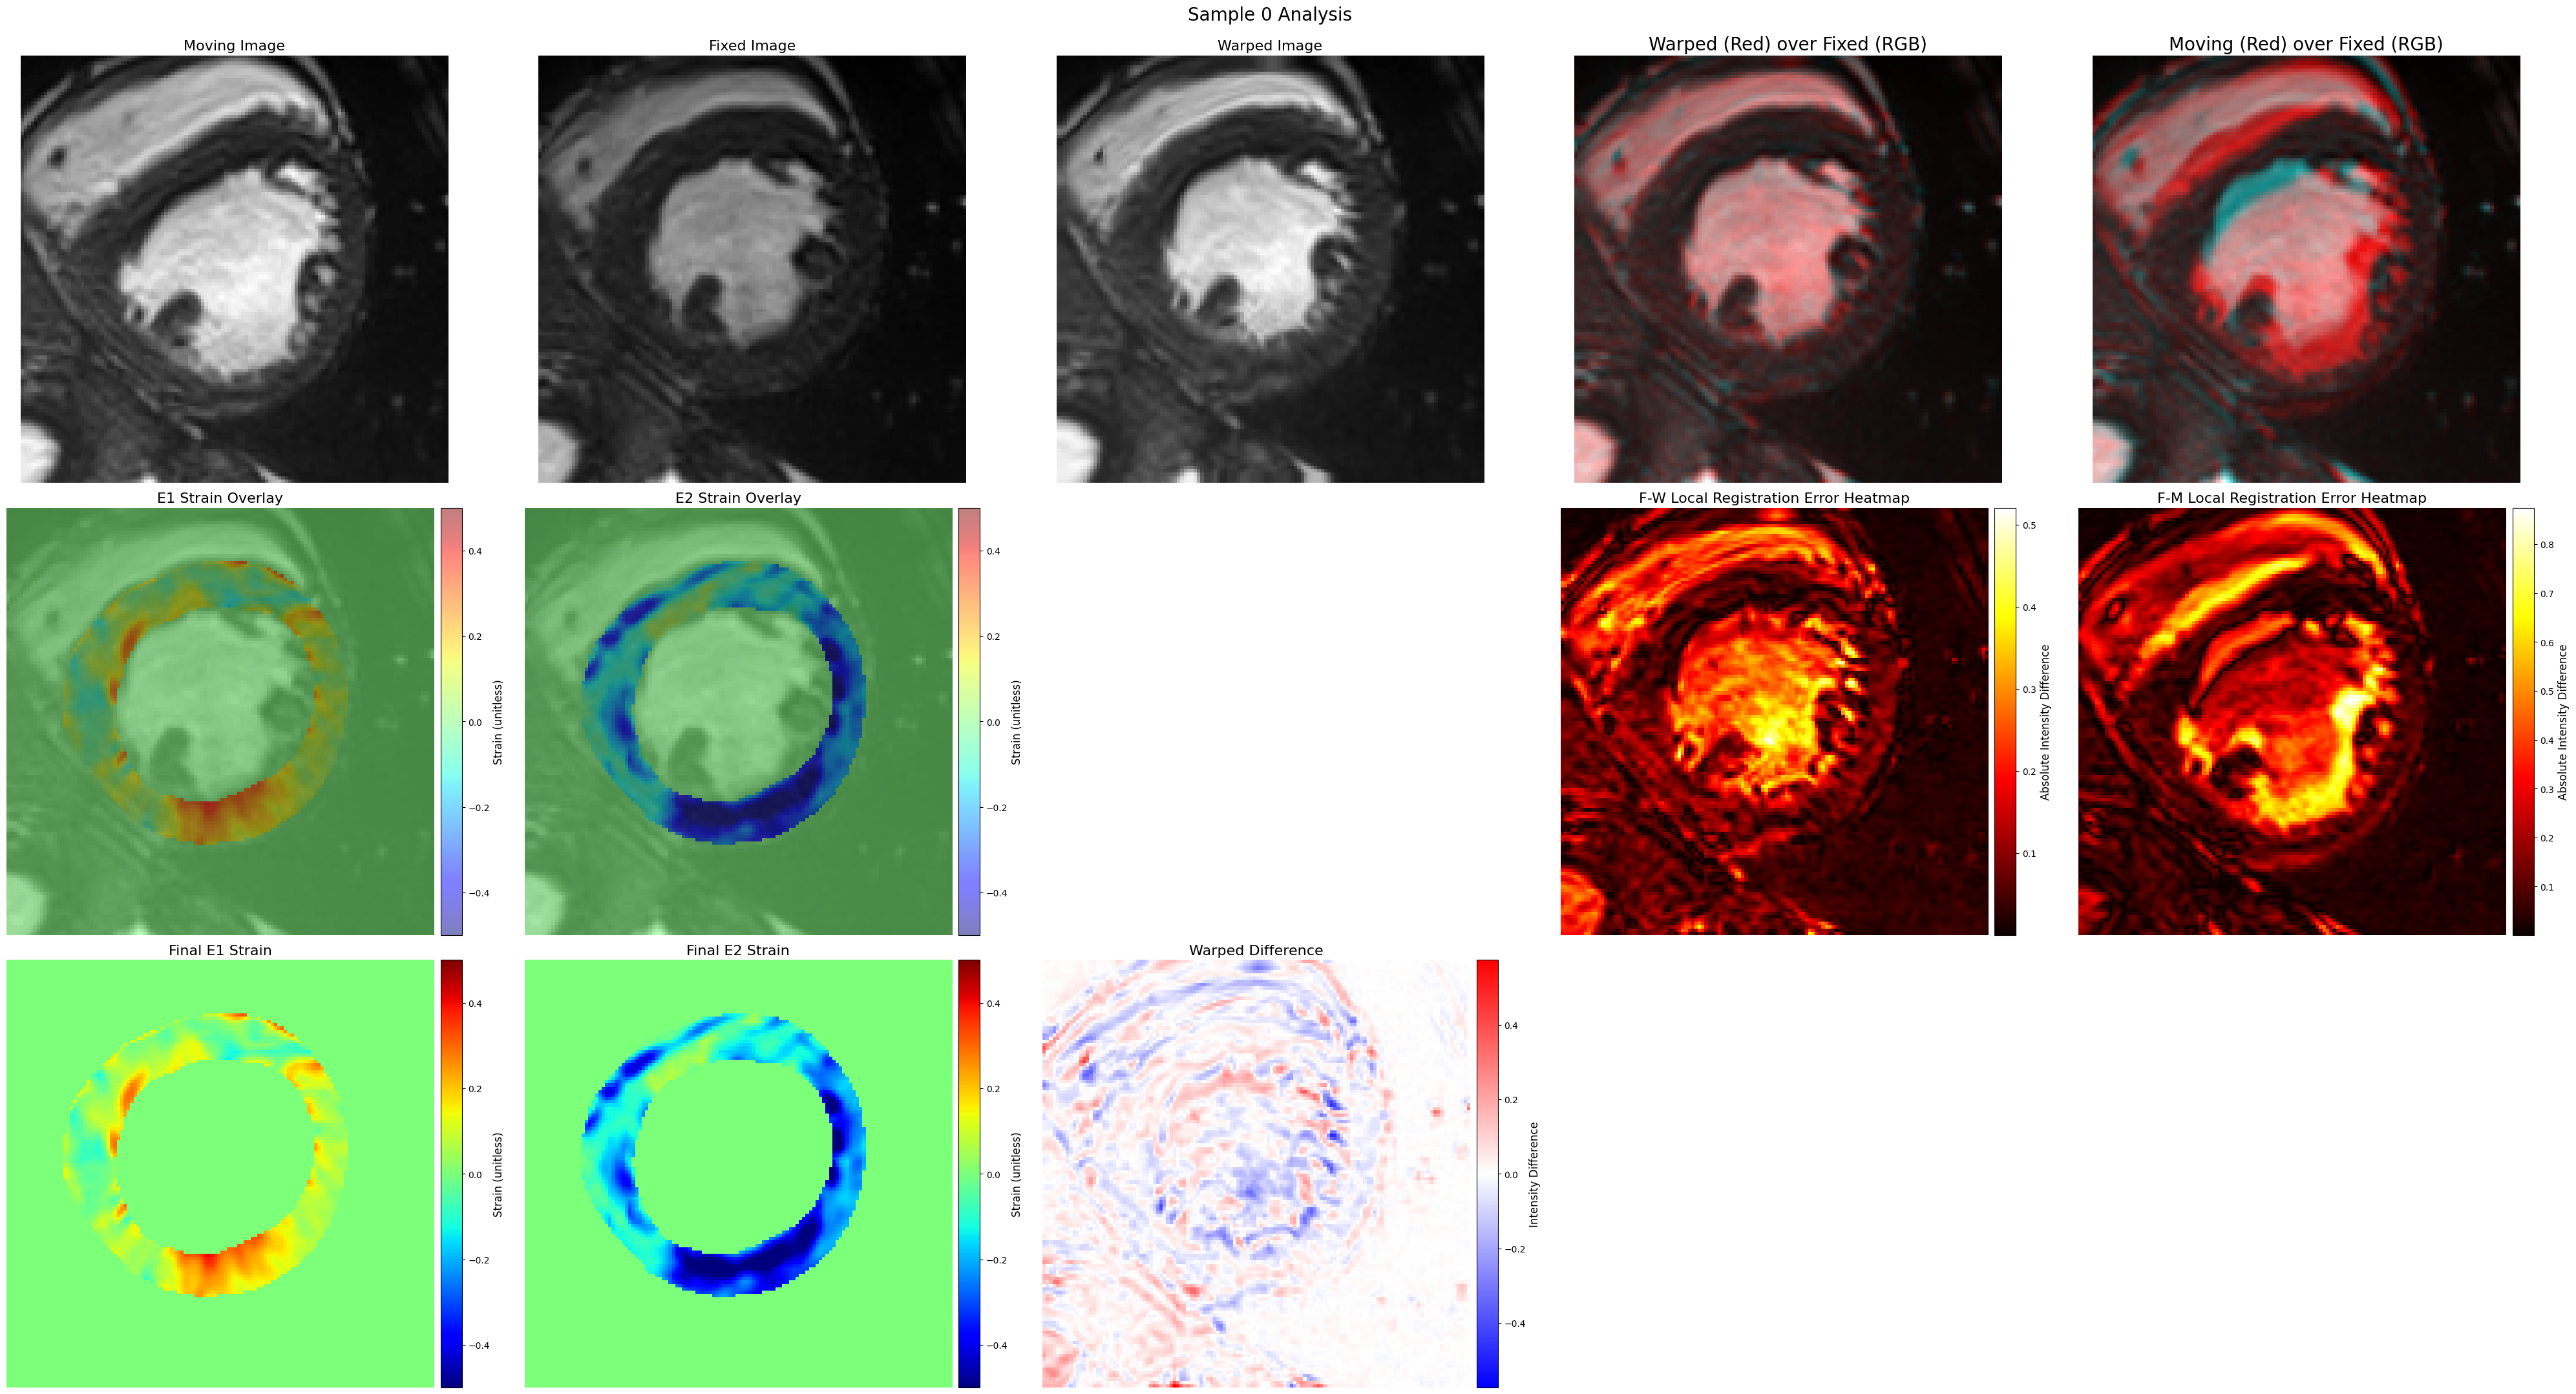

In [25]:
data = {
    'moving': moving_image[0, ..., 0],
    'fixed': fixed_image[0, ..., 0],
    'warped': warped[0, ..., 0],
    'displacements': pred_disp[0],
    'mask': fixed_mask
}
# Create interactive plots
create_interactive_plots(data, sample_idx=0, MODEL_TESTING_PATH='Best_model/patient5', model_name="Unsupervised No mask Default kernel Lambda = 0.1 Model")

In [69]:
# Visualize and save the results
save_dir = 'Best_model'
save_images(moving_image, fixed_image, warped, pred_disp, save_dir, batch_idx=0, fixed_mask=fixed_mask)
# Print completion message
print(f"Results saved to {save_dir} for batch index 0.")

Results saved to Best_model for batch index 0.


In [41]:
# Load Simulated data
moving_simulated_data_path = 'data/Simulated_test/patient074/patient074_t01_z02#39_1.npy'
fixed_simulated_data_path = 'data/Simulated_test/patient074/patient074_t01_z02#39.npy'

displacement_x_simulated_data_path = 'data/Simulated_displacements/patient074/patient074_t01_z02#39_x.npy'
displacement_y_simulated_data_path = 'data/Simulated_displacements/patient074/patient074_t01_z02#39_y.npy'
# Load the simulated images
moving_simulated_image = np.load(moving_simulated_data_path)
fixed_simulated_image = np.load(fixed_simulated_data_path)
# Load the simulated displacement fields
displacement_x_simulated = np.load(displacement_x_simulated_data_path)
displacement_y_simulated = np.load(displacement_y_simulated_data_path)
# Print the shapes of the simulated images and displacements
print(f"Moving Simulated image shape: {moving_simulated_image.shape}")
print(f"Fixed Simulated image shape: {fixed_simulated_image.shape}")
print(f"Displacement X Simulated shape: {displacement_x_simulated.shape}")
print(f"Displacement Y Simulated shape: {displacement_y_simulated.shape}")


Moving Simulated image shape: (128, 128)
Fixed Simulated image shape: (128, 128)
Displacement X Simulated shape: (128, 128)
Displacement Y Simulated shape: (128, 128)


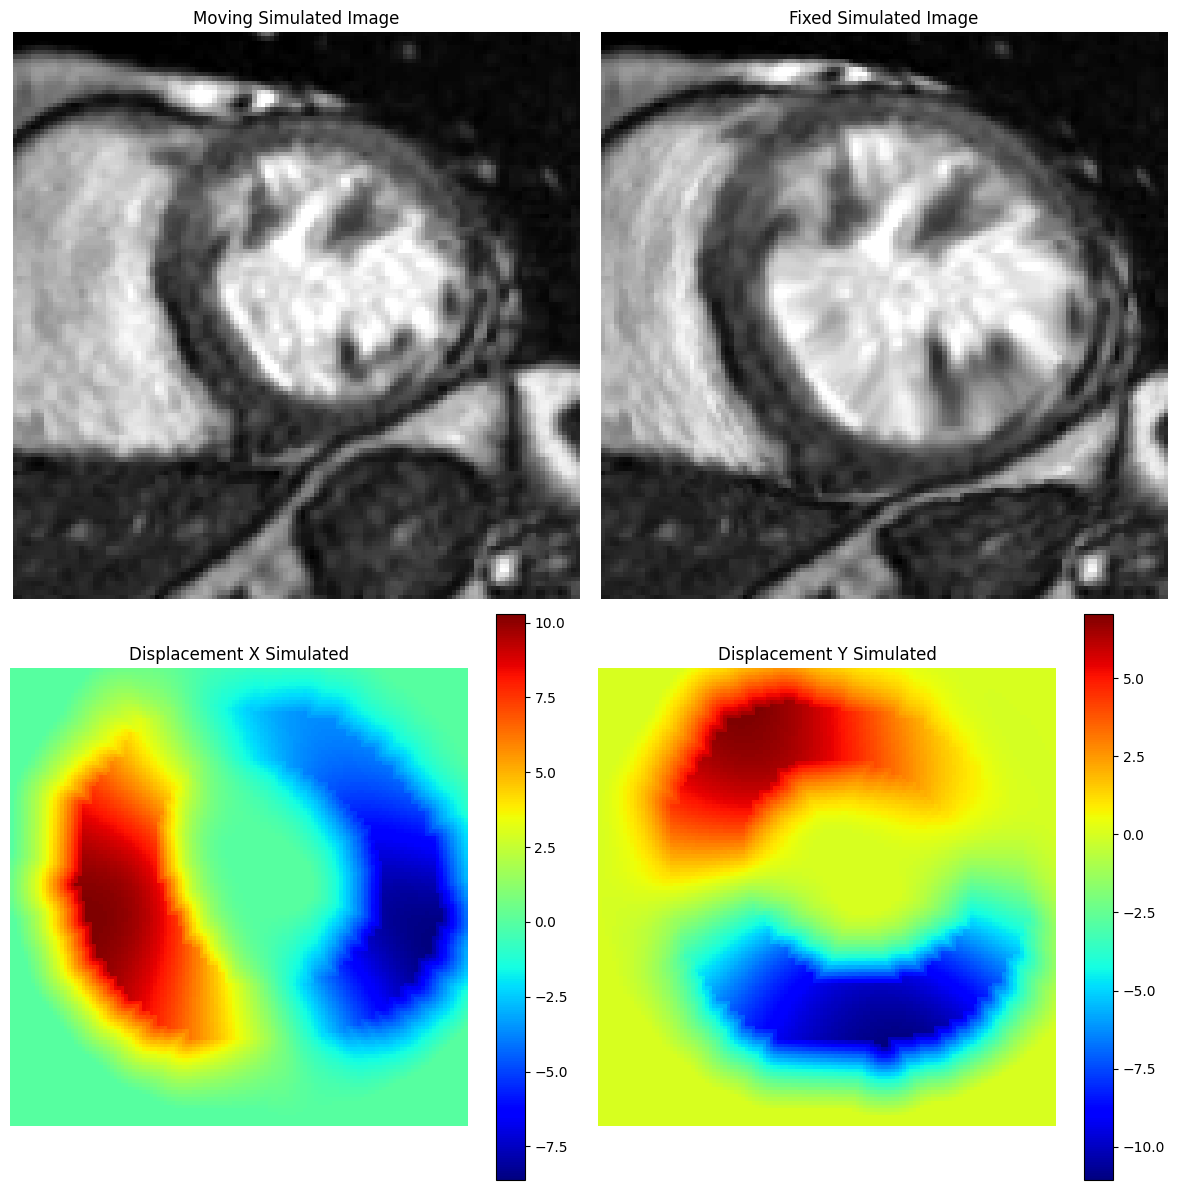

In [52]:
# Plot the simulated images and displacements in a 2x2 grid
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(moving_simulated_image.squeeze(), cmap='gray')
plt.title('Moving Simulated Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(fixed_simulated_image.squeeze(), cmap='gray')
plt.title('Fixed Simulated Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(displacement_x_simulated.squeeze(), cmap='jet')
plt.title('Displacement X Simulated')
plt.colorbar()
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(displacement_y_simulated.squeeze(), cmap='jet')
plt.title('Displacement Y Simulated')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
# Prepare simulated images for prediction
moving_simulated_image = np.expand_dims(moving_simulated_image, axis=0)
fixed_simulated_image = np.expand_dims(fixed_simulated_image, axis=0)
# Ensure simulated images have the correct shape
moving_simulated_image = np.expand_dims(moving_simulated_image, axis=-1)
fixed_simulated_image = np.expand_dims(fixed_simulated_image, axis=-1)  
# Print new shapes for simulated images
print(f"Moving Simulated image shape after expansion: {moving_simulated_image.shape}")  
print(f"Fixed Simulated image shape after expansion: {fixed_simulated_image.shape}")

Moving Simulated image shape after expansion: (1, 128, 128, 1)
Fixed Simulated image shape after expansion: (1, 128, 128, 1)


In [44]:
#predict the deformation field for simulated data
predictions_simulated = model.predict([moving_simulated_image, fixed_simulated_image])
# Extract the warped image and predicted displacement field
warped_simulated, pred_disp_simulated = predictions_simulated
# Print the shapes of the predictions for simulated data
print(f"Warped Simulated image shape: {warped_simulated.shape}")
print(f"Predicted displacement field shape for simulated data: {pred_disp_simulated.shape}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Warped Simulated image shape: (1, 128, 128, 1)
Predicted displacement field shape for simulated data: (1, 128, 128, 2)


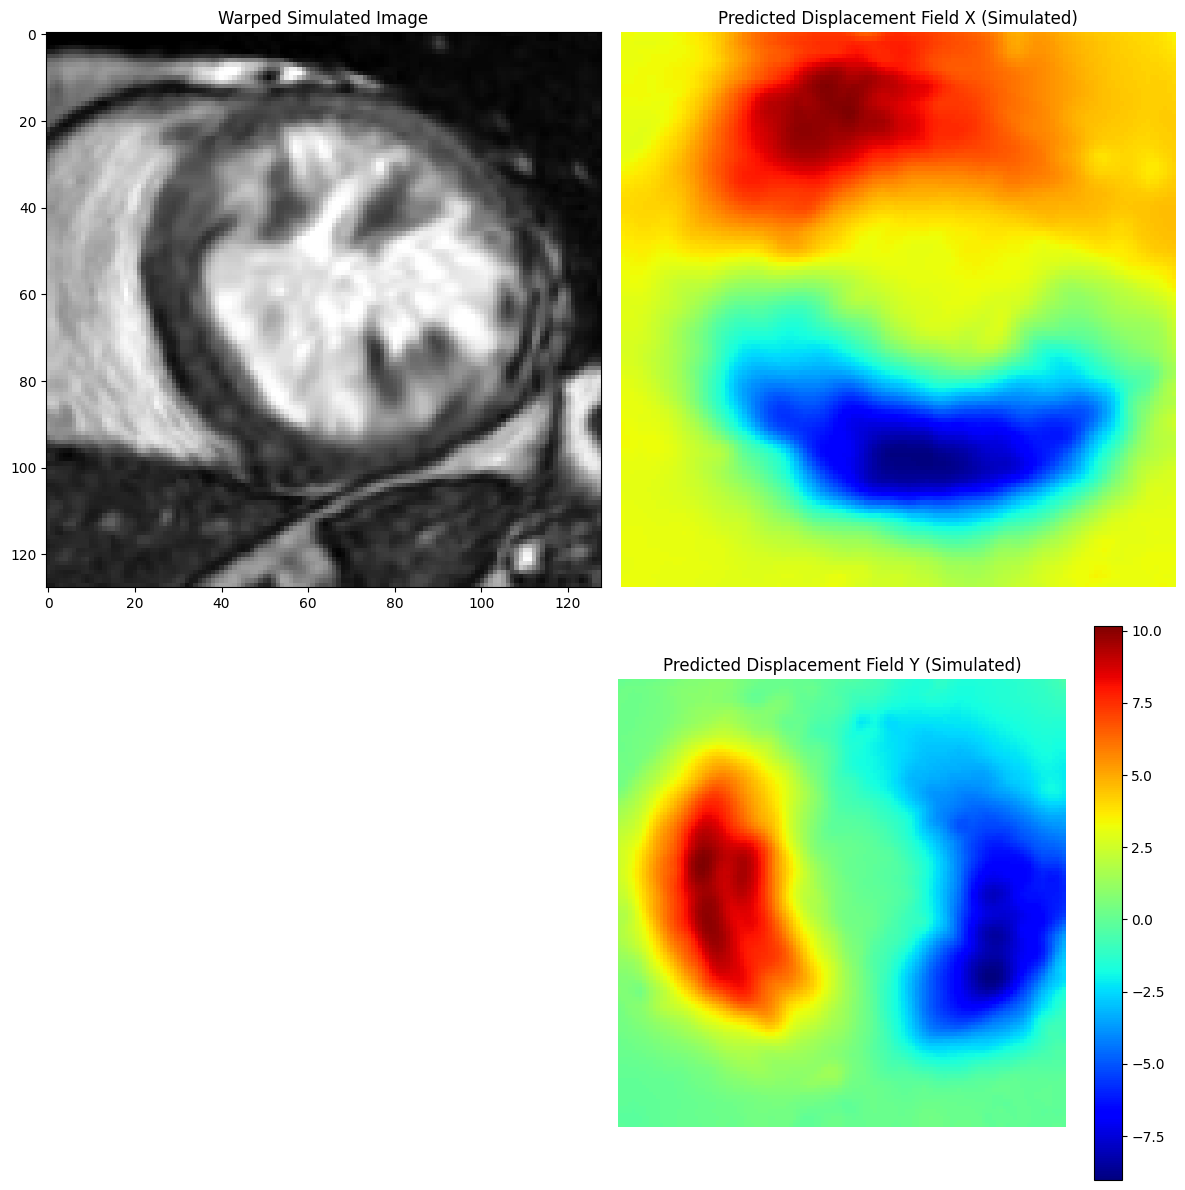

In [55]:
# Plot the predicted warped image and displacement fields for simulated data
# Plot the simulated images and displacements in a 2x2 grid
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(warped_simulated.squeeze(), cmap='gray')
plt.title('Warped Simulated Image')

plt.subplot(2, 2, 2)
plt.imshow(pred_disp_simulated[..., 0].squeeze(), cmap='jet')
plt.title('Predicted Displacement Field X (Simulated)')
plt.axis('off')


plt.subplot(2, 2, 4)
plt.imshow(pred_disp_simulated[..., 1].squeeze(), cmap='jet')
plt.title('Predicted Displacement Field Y (Simulated)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()





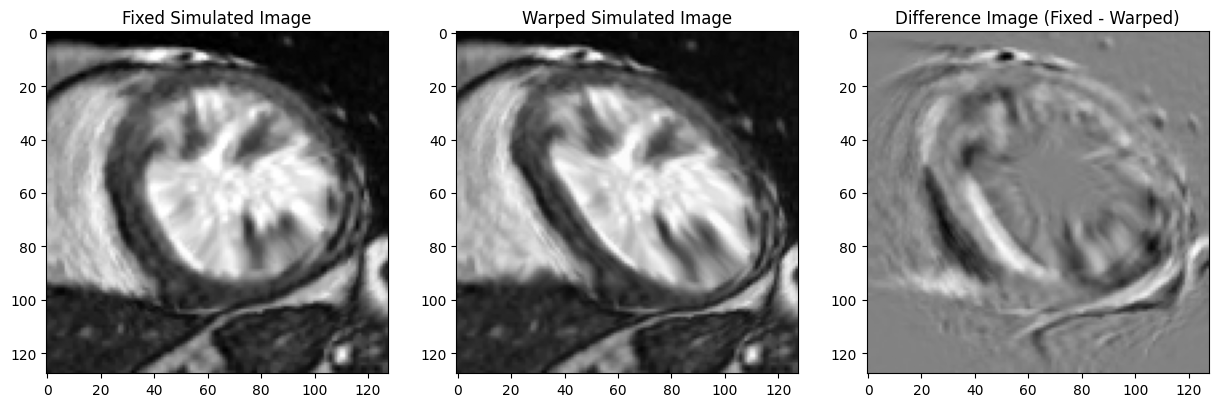

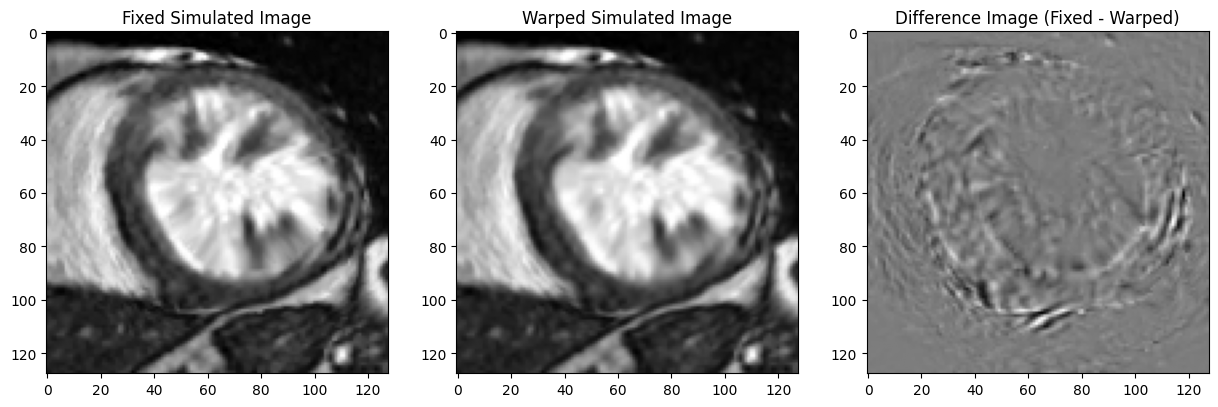

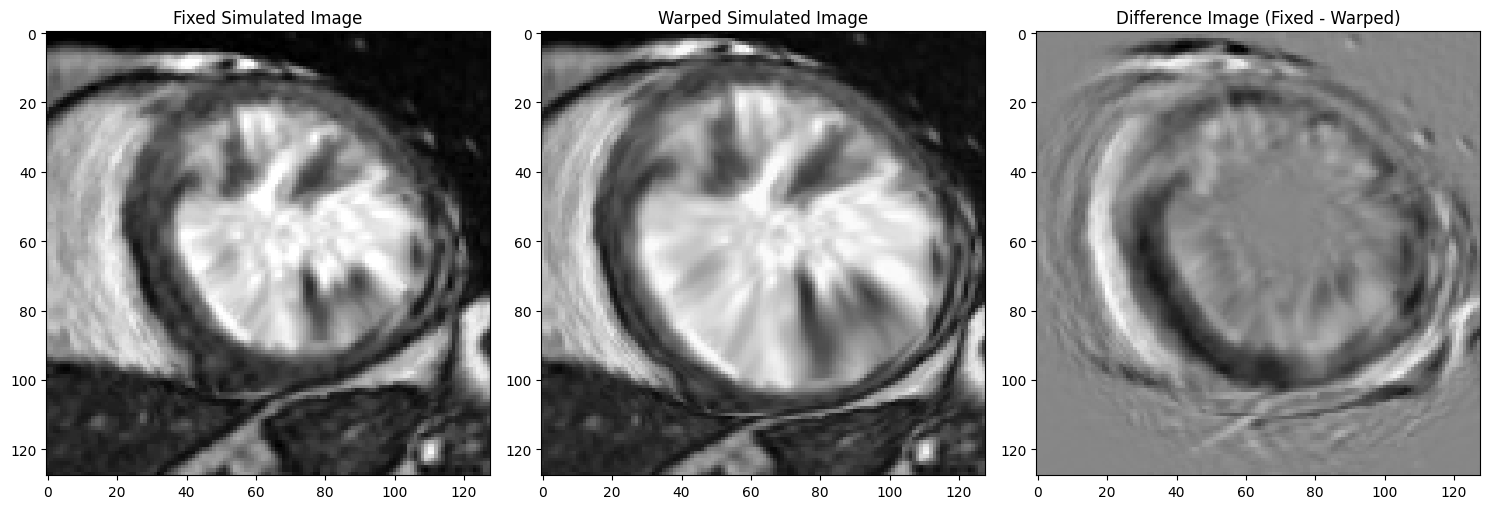

In [56]:
# Plot Fixed , Warped, Warped - Fixed in one row
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(fixed_simulated_image.squeeze(), cmap='gray')
plt.title('Fixed Simulated Image')
plt.subplot(1, 3, 2)
# Apply the displacement fields to the fixed image
warped_transformed = apply_displacement(fixed_simulated_image.squeeze(), 
                                                     pred_disp_simulated[..., 0].squeeze(), 
                                                     pred_disp_simulated[..., 1].squeeze())
plt.imshow(warped_transformed.squeeze(), cmap='gray')
plt.title('Warped Simulated Image')
plt.subplot(1, 3, 3)
# Calculate the difference between the warped and fixed images
difference_image = fixed_simulated_image.squeeze() - warped_transformed
plt.imshow(difference_image, cmap='gray')
plt.title('Difference Image (Fixed - Warped)')

# Plot in the Second row Fixed, Warped, Warped - Fixed
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(fixed_simulated_image.squeeze(), cmap='gray')
plt.title('Fixed Simulated Image')
plt.subplot(1, 3, 2)
plt.imshow(warped_simulated.squeeze(), cmap='gray')
plt.title('Warped Simulated Image')
plt.subplot(1, 3, 3)
# Calculate the difference between the warped and fixed images
difference_image_simulated = fixed_simulated_image.squeeze() - warped_simulated.squeeze()
plt.imshow(difference_image_simulated, cmap='gray')
plt.title('Difference Image (Fixed - Warped)')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(fixed_simulated_image.squeeze(), cmap='gray')
plt.title('Fixed Simulated Image')
plt.subplot(1, 3, 2)
# Apply the displacement fields to the fixed image
warped_transformed = apply_displacement(fixed_simulated_image.squeeze(), 
                                                     pred_disp_simulated[..., 1].squeeze(), 
                                                     pred_disp_simulated[..., 0].squeeze())
plt.imshow(warped_transformed.squeeze(), cmap='gray')
plt.title('Warped Simulated Image')
plt.subplot(1, 3, 3)
# Calculate the difference between the warped and fixed images
difference_image = fixed_simulated_image.squeeze() - warped_transformed
plt.imshow(difference_image, cmap='gray')
plt.title('Difference Image (Fixed - Warped)')

plt.tight_layout()
plt.show()